[*********************100%***********************]  1 of 1 completed
<ipython-input-6-4cc4d1aa6d66>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data.dropna(inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-6-4cc4d1aa6d66>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data.dropna(inplace=True)
[*********************100%***********************]  1 of 1 completed
<ipython-input-6-4cc4d1aa6d66>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.1901 - val_loss: 0.1830
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0277 - val_loss: 0.0074
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125 - val_loss: 0.0360
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - val_loss: 0.0043
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 0.0049
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - va

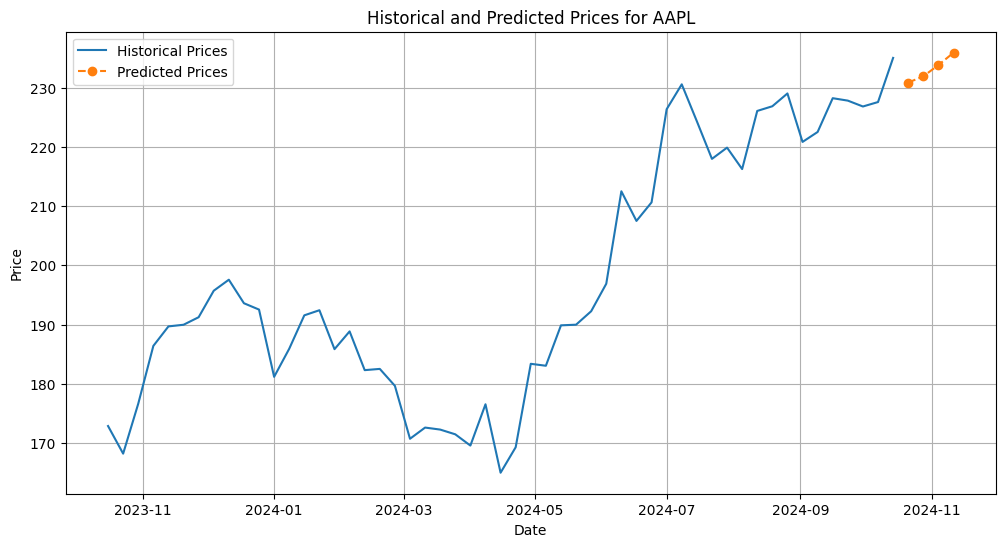

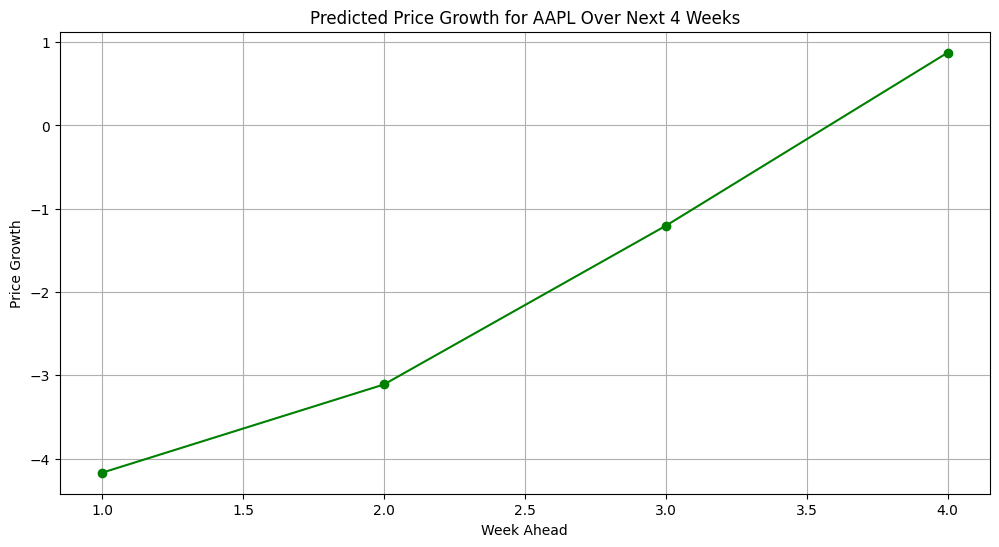

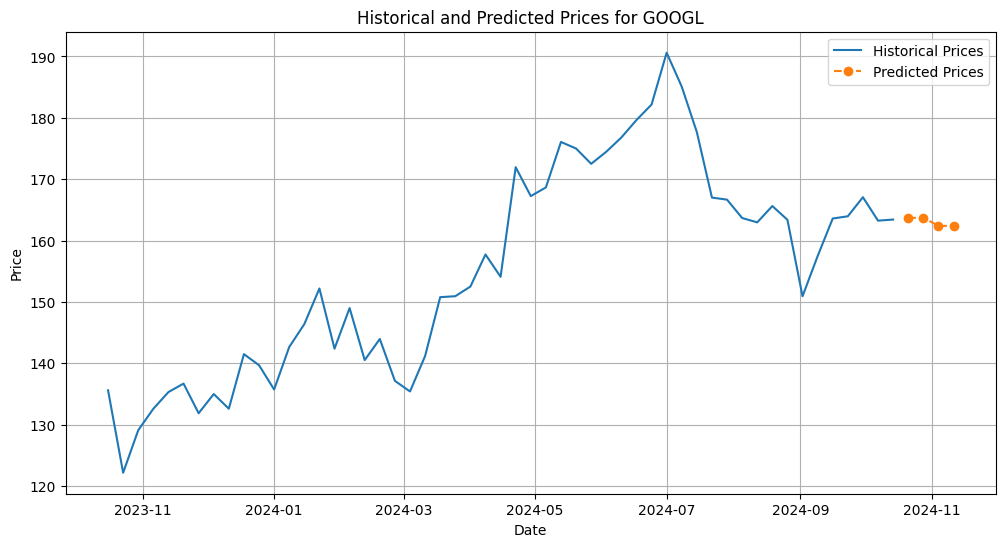

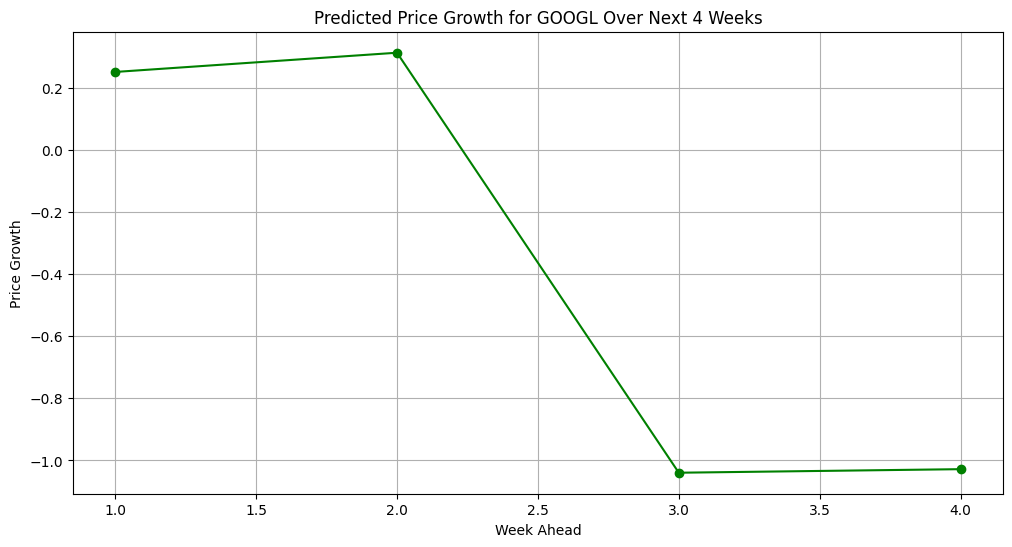

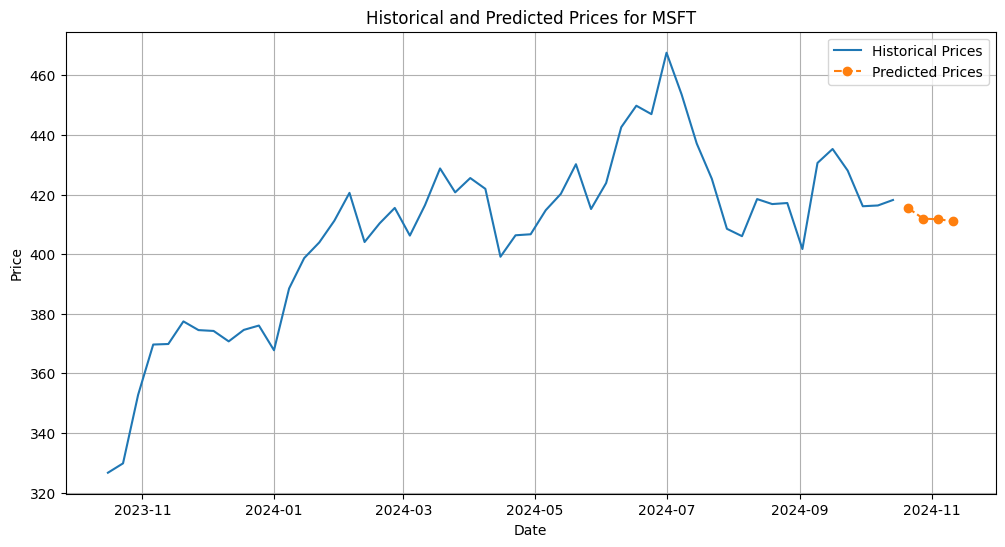

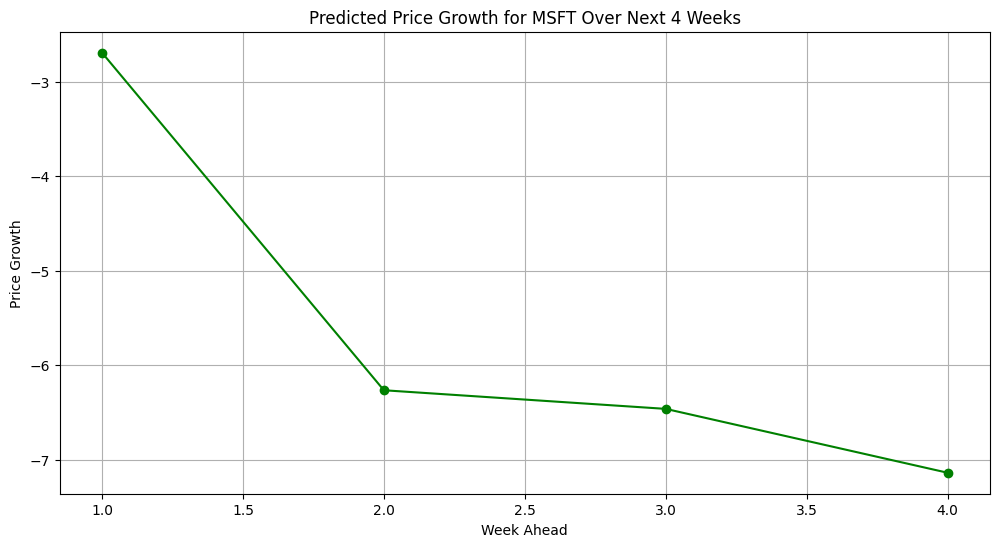

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import yfinance as yf

# Step 1: Fetch data from Yahoo Finance
def fetch_stock_data(tickers, period='5y'):
    merged_data = pd.DataFrame()
    for ticker in tickers:
        try:
            # Fetch historical data
            stock_data = yf.download(ticker, period=period, interval='1wk')  # Weekly data
            if stock_data.empty:
                print(f"No data fetched for {ticker}. Skipping.")
                continue
            stock_data.reset_index(inplace=True)
            # Ensure 'Date' column exists
            if 'Date' not in stock_data.columns:
                stock_data.rename(columns={'index': 'Date'}, inplace=True)
            stock_data['Ticker'] = ticker
            # Select necessary columns
            stock_data = stock_data[['Date', 'Ticker', 'Close']]
            # Drop rows with NaN values
            stock_data.dropna(inplace=True)
            merged_data = pd.concat([merged_data, stock_data], ignore_index=True)
        except yf.shared.YFInvalidPeriodError as e:
            print(f"Invalid period error for {ticker}: {e}")
            continue
        except Exception as e:
            print(f"An error occurred while fetching data for {ticker}: {e}")
            continue
    # Check if 'Ticker' column exists
    if 'Ticker' not in merged_data.columns or merged_data.empty:
        print("No data was fetched for any ticker. Exiting.")
        exit()
    # Sort data
    merged_data.sort_values(by=['Ticker', 'Date'], inplace=True)
    return merged_data

# Step 2: Prepare data
def prepare_data(merged_data, lookback=4):
    tickers = merged_data['Ticker'].unique()
    data_list = []

    for ticker in tickers:
        ticker_data = merged_data[merged_data['Ticker'] == ticker].copy()
        features = ticker_data[['Close']].values

        if len(features) < lookback + 1:
            print(f"Not enough data for {ticker} after considering lookback. Skipping this ticker.")
            continue

        for i in range(lookback, len(features)):
            data_list.append({
                'Ticker': ticker,
                'X': features[i - lookback:i],
                'y': features[i][0]
            })

    if not data_list:
        raise ValueError("No data available after processing. Check the input data and lookback period.")

    data_df = pd.DataFrame(data_list)
    return data_df

# Step 3: Train LSTM model
def train_lstm_model(data_df):
    # Sort data to maintain time order
    data_df = data_df.reset_index(drop=True)

    # Split data into training, validation, and test sets
    total_samples = len(data_df)
    train_size = int(total_samples * 0.6)
    val_size = int(total_samples * 0.2)

    train_data = data_df.iloc[:train_size]
    val_data = data_df.iloc[train_size:train_size + val_size]
    test_data = data_df.iloc[train_size + val_size:]

    # Prepare scaler using training data
    scaler = MinMaxScaler()

    # Stack the sequences for scaling
    X_train = np.stack(train_data['X'].values)
    y_train = train_data['y'].values

    X_train_reshaped = X_train.reshape(-1, 1)
    y_train_reshaped = y_train.reshape(-1, 1)

    # Fit scaler on training data
    scaler.fit(np.vstack((X_train_reshaped, y_train_reshaped)))

    # Scale training data
    X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
    y_train_scaled = scaler.transform(y_train_reshaped)

    # Scale validation data
    X_val = np.stack(val_data['X'].values)
    y_val = val_data['y'].values
    X_val_reshaped = X_val.reshape(-1, 1)
    y_val_reshaped = y_val.reshape(-1, 1)
    X_val_scaled = scaler.transform(X_val_reshaped).reshape(X_val.shape)
    y_val_scaled = scaler.transform(y_val_reshaped)

    # Scale test data
    X_test = np.stack(test_data['X'].values)
    y_test = test_data['y'].values
    X_test_reshaped = X_test.reshape(-1, 1)
    y_test_reshaped = y_test.reshape(-1, 1)
    X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)
    y_test_scaled = scaler.transform(y_test_reshaped)

    # Build the LSTM model
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(
        X_train_scaled, y_train_scaled,
        epochs=20, batch_size=32,
        validation_data=(X_val_scaled, y_val_scaled)
    )

    return model, scaler

# Step 4: Predict future stock prices
def predict_future_prices(model, merged_data, scaler, future_weeks, lookback=4):
    tickers = merged_data['Ticker'].unique()
    predictions = {}

    for ticker in tickers:
        ticker_data = merged_data[merged_data['Ticker'] == ticker].copy()
        features = ticker_data[['Close']].values

        # Ensure there is enough data
        if len(features) < lookback:
            print(f"Not enough data for {ticker} to make predictions. Skipping.")
            continue

        # Get the last 'lookback' data points
        input_sequence = features[-lookback:]

        # Scale the input sequence
        input_sequence_scaled = scaler.transform(input_sequence)

        ticker_predictions = []

        # Predict future prices
        for _ in range(future_weeks):
            input_sequence_scaled = input_sequence_scaled.reshape(1, lookback, 1)
            predicted_price_scaled = model.predict(input_sequence_scaled)
            predicted_price = scaler.inverse_transform(predicted_price_scaled)[0][0]
            ticker_predictions.append(predicted_price)

            # Update the input sequence
            input_sequence = np.append(input_sequence[1:], [[predicted_price]], axis=0)
            input_sequence_scaled = scaler.transform(input_sequence)

        predictions[ticker] = ticker_predictions

    return predictions

# Step 5: Calculate price growth
def calculate_price_growth(merged_data, predictions):
    price_growth_list = []

    for ticker, ticker_predictions in predictions.items():
        last_close_price = merged_data[merged_data['Ticker'] == ticker]['Close'].iloc[-1]

        for week_ahead, predicted_price in enumerate(ticker_predictions, start=1):
            growth = predicted_price - last_close_price
            price_growth_list.append({
                'Ticker': ticker,
                'Week Ahead': week_ahead,
                'Predicted Price': predicted_price,
                'Price Growth': growth
            })

    price_growth_df = pd.DataFrame(price_growth_list)
    return price_growth_df

# Step 6: Plot predictions, price growth, and historical data
def plot_historical_and_predictions(merged_data, price_growth_df, future_weeks):
    tickers = price_growth_df['Ticker'].unique()

    for ticker in tickers:
        # Filter data for the current ticker
        ticker_data = merged_data[merged_data['Ticker'] == ticker]

        # Get the last 1 year of historical data
        last_year_date = ticker_data['Date'].max() - pd.DateOffset(years=1)
        ticker_data_last_year = ticker_data[ticker_data['Date'] >= last_year_date]

        # Prepare data for plotting
        dates = list(ticker_data_last_year['Date'])
        prices = list(ticker_data_last_year['Close'])

        # Prepare future dates for predictions
        last_date = ticker_data['Date'].max()
        future_dates = [last_date + pd.DateOffset(weeks=1 * i) for i in range(1, future_weeks + 1)]
        predicted_prices = price_growth_df[price_growth_df['Ticker'] == ticker]['Predicted Price'].values

        # Plot historical prices
        plt.figure(figsize=(12, 6))
        plt.plot(dates, prices, label='Historical Prices')

        # Plot predicted prices
        plt.plot(future_dates, predicted_prices, marker='o', linestyle='--', label='Predicted Prices')

        plt.title(f'Historical and Predicted Prices for {ticker}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot price growth
        ticker_growth_data = price_growth_df[price_growth_df['Ticker'] == ticker]
        plt.figure(figsize=(12, 6))
        plt.plot(ticker_growth_data['Week Ahead'], ticker_growth_data['Price Growth'], marker='o', color='green')
        plt.title(f'Predicted Price Growth for {ticker} Over Next {future_weeks} Weeks')
        plt.xlabel('Week Ahead')
        plt.ylabel('Price Growth')
        plt.grid(True)
        plt.show()

# Main execution
if __name__ == "__main__":
    # Define the tickers and period
    tickers = ['AAPL', 'GOOGL', 'MSFT']  # List of tickers to analyze
    period = '5y'  # Changed from '3y' to '5y' (valid period)

    # Step 1: Fetch stock data
    merged_data = fetch_stock_data(tickers, period)

    # Check if any data was fetched
    if merged_data.empty or 'Ticker' not in merged_data.columns:
        print("No data was fetched. Exiting.")
        exit()

    # Update tickers list based on data fetched
    tickers = merged_data['Ticker'].unique()

    # Step 2: Prepare the data
    data_df = prepare_data(merged_data, lookback=4)

    if data_df.empty:
        print("No data available after processing. Exiting.")
        exit()

    # Step 3: Train the model
    model, scaler = train_lstm_model(data_df)

    # Step 4: Predict future prices
    future_weeks = 4  # Number of weeks to predict into the future
    predictions = predict_future_prices(model, merged_data, scaler, future_weeks, lookback=4)

    if not predictions:
        print("No predictions were made. Exiting.")
        exit()

    # Step 5: Calculate price growth
    price_growth_df = calculate_price_growth(merged_data, predictions)

    # Display the results
    print(price_growth_df)

    # Step 6: Plot the historical data and predictions
    plot_historical_and_predictions(merged_data, price_growth_df, future_weeks)
